<a href="https://colab.research.google.com/github/Ortimus/AmazonSageMakerCourse/blob/master/PerformanceEvaluation/multiclass_classifier_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Performance of a Multi-class Classifier
Multi-class Model is used for predicting one of many possible outcomes

<i>Exam Grades: A, B, C, D  
Dress Size: Small, Medium, Large, X-Large</i>

<q><i>Typical metrics used in multiclass are the same as the metrics used in the binary classification case. The metric is calculated for each class by treating it as a binary classification problem after grouping all the other classes as belonging to the second class. Then the binary metric is averaged over all the classes to get either a macro average (treat each class equally) or weighted average (weighted by class frequency) metric.</i></q>

Reference:<br>
https://docs.aws.amazon.com/machine-learning/latest/dg/multiclass-classification.html

To find out how good the model predictions are, we need to check predictions against previously unseen samples that were not used for training.  Usually, 30% of the available samples are reserved for testing while remaining 70% of samples are used for training.

By comparing predicted values against known results in test data, we can assess overall model performance<br>

Common Techniques for evaluating performance:<br>
<li>Visually observe using Plots</li>
<li>Confusion Matrix</li>
<li>Evaluate with Metrics like Recall, Precision, F1 Score and so forth</li>

<p>While Plots are good for humans to visually observe the results, we often need a single metric that can indicate quality of a model. This can be useful for programmatically identifying which model is performing better (for example: using automatic model tuning to select the best performing model)</p>

Reference:<br>https://docs.aws.amazon.com/machine-learning/latest/dg/multiclass-classification.html<br>
Confusion Matrix:<br>https://en.wikipedia.org/wiki/Confusion_matrix<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
import requests
import os

# Create directory if it doesn't exist
folder_name = "PerformanceEvaluation"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Download specific file
file_name = "IrisSample.csv"
url = f"https://raw.githubusercontent.com/Ortimus/AmazonSageMakerCourse/master/PerformanceEvaluation/{file_name}"
response = requests.get(url)

# Save to file
with open(f"{folder_name}/{file_name}", "wb") as f:
    f.write(response.content)

print(f"Downloaded {file_name} to {folder_name}/")

Downloaded IrisSample.csv to PerformanceEvaluation/


In [3]:
models = ['Model 1','Model 2', 'Model 3', 'Model 4']

# Labeled Classes
labels=[0,1,2]

# Class Names
# Setosa = 0, Versicolor = 1, Virginica = 2
classes = ['Setosa','Versicolor','Virginica']

df = pd.read_csv('./PerformanceEvaluation/IrisSample.csv')

In [4]:
df.head(15)

,sepal_length,sepal_width,petal_length,petal_width,class,NumericClass,Model1_Prediction,Model2_Prediction,Model3_Prediction,Model4_Prediction
0,5.8,4.0,1.2,0.2,Iris-setosa,0,0,1,0,0
1,5.7,4.4,1.3,0.4,Iris-setosa,0,1,1,0,1
2,5.1,3.4,1.5,0.2,Iris-setosa,0,0,1,0,2
3,5.4,3.9,1.7,0.4,Iris-setosa,0,0,1,0,2
4,4.3,3.0,1.1,0.1,Iris-setosa,0,1,1,0,1
5,4.9,2.4,3.3,1.0,Iris-versicolor,1,1,1,1,0
6,5.9,3.0,4.2,1.5,Iris-versicolor,1,1,1,2,1
7,6.6,3.0,4.4,1.4,Iris-versicolor,1,2,1,1,2
8,5.0,2.3,3.3,1.0,Iris-versicolor,1,1,1,2,0
9,6.2,2.9,4.3,1.3,Iris-versicolor,1,1,1,1,0


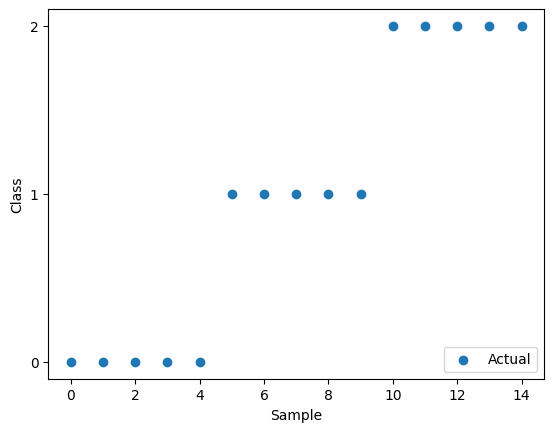

In [5]:
plt.figure()
plt.scatter(df.index,df['NumericClass'],label='Actual')
plt.legend(loc=4)
plt.yticks([0,1,2])
plt.xlabel('Sample')
plt.ylabel('Class')
plt.show()

## Plot Data
Compare performance visually <br>

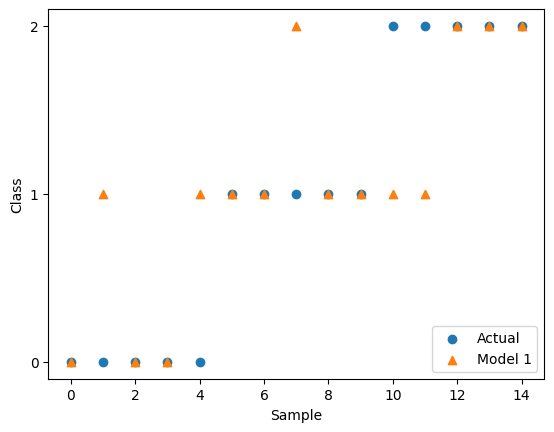

In [6]:
# Compare performance of Actual and Model 1 Prediction
plt.figure()
plt.scatter(df.index,df['NumericClass'],label='Actual')
plt.scatter(df.index,df['Model1_Prediction'],label='Model 1',marker='^')
plt.legend(loc=4)
plt.yticks([0,1,2])
plt.xlabel('Sample')
plt.ylabel('Class')
plt.show()

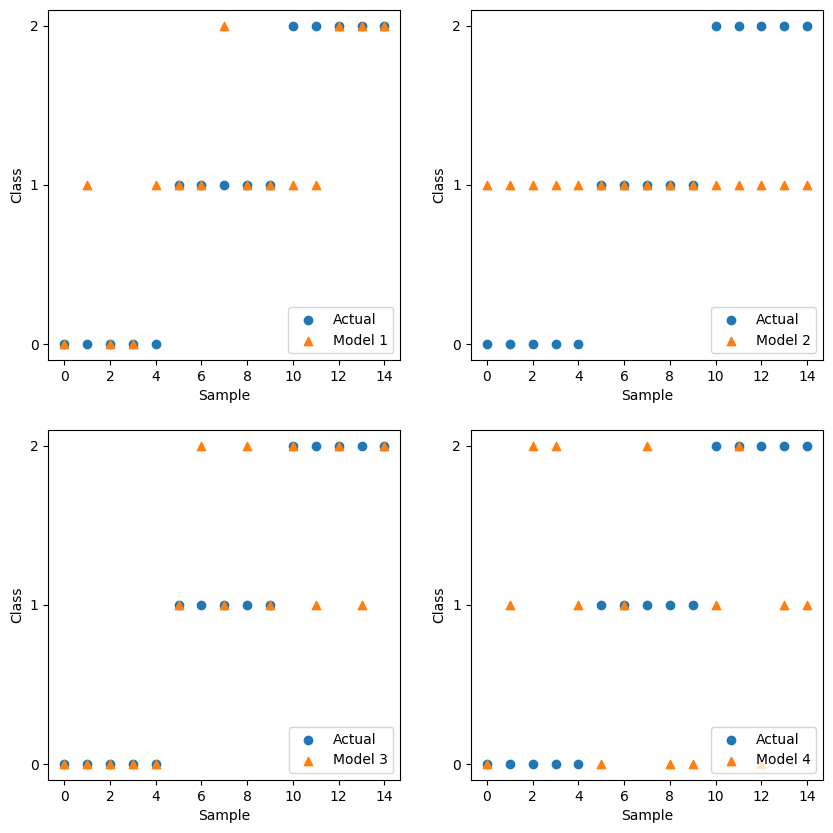

In [7]:
plt.figure(figsize=(10,10))

for idx, model in enumerate(models):
    plt.subplot(2,2,idx+1)

    plt.scatter(df.index,df['NumericClass'],label='Actual')
    plt.scatter(df.index,df[model.replace(' ','') + '_Prediction'],
                label=model,marker='^')
    plt.yticks([0,1,2])
    plt.legend(loc=4)
    plt.xlabel('Sample')
    plt.ylabel('Class')

<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [8]:
from sklearn.metrics import classification_report,confusion_matrix

In [9]:
# Reference:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [10]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['NumericClass'],
                              df['Model1_Prediction'],labels=labels)

In [11]:
cnf_matrix

array([[3, 2, 0],
       [0, 4, 1],
       [0, 2, 3]])

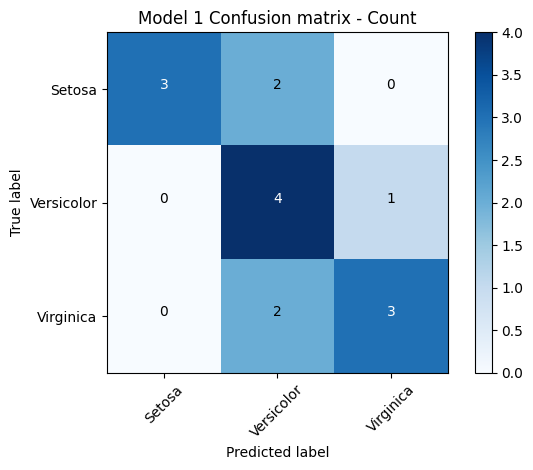

In [12]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Model 1 Confusion matrix - Count')

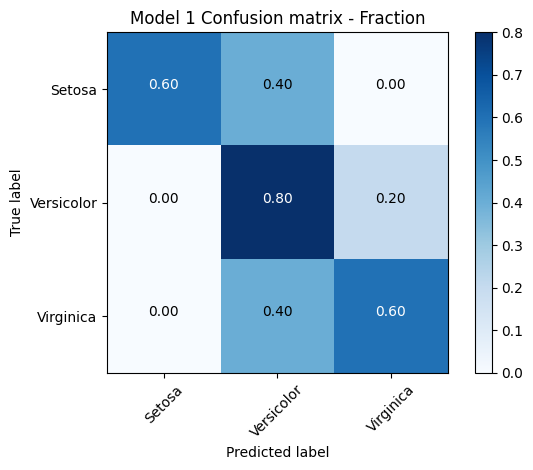

In [13]:
# Plot normalized confusion matrix (ratio)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Model 1 Confusion matrix - Fraction',normalize=True)

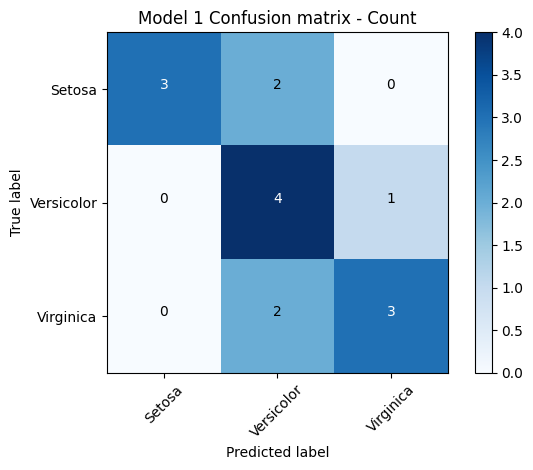

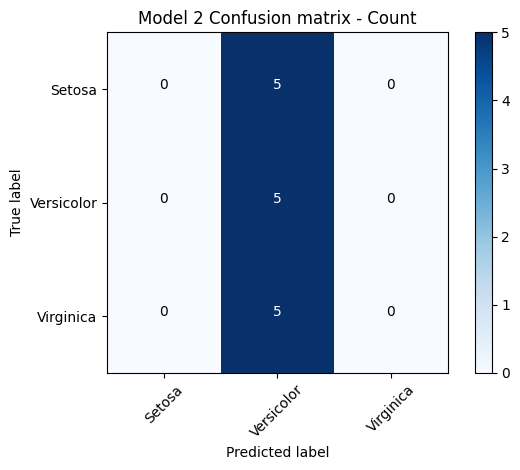

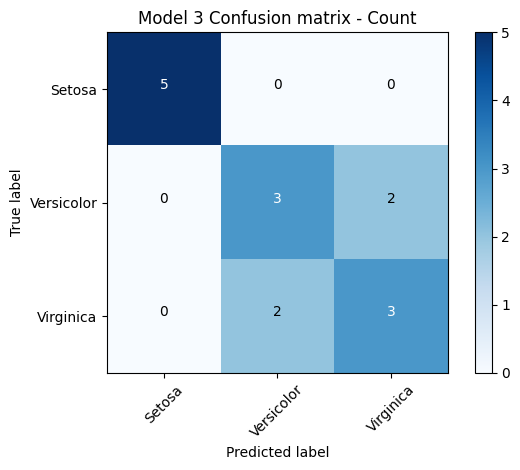

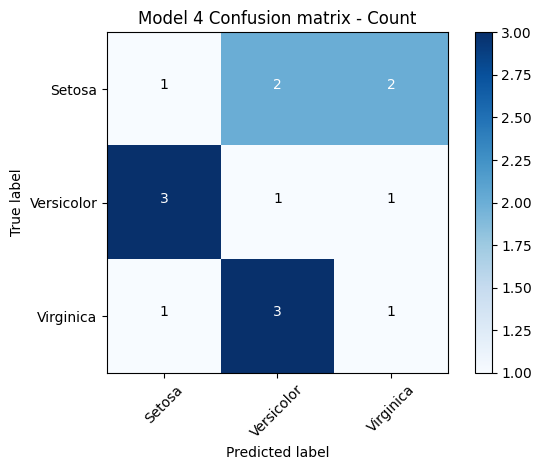

In [14]:
# Plot confusion matrix
# Show actual counts
for model in models:
    #print(model)
    cnf_matrix = confusion_matrix(df['NumericClass'],
                                  df[model.replace(' ','') + '_Prediction'],
                                  labels=labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title= model + ' Confusion matrix - Count', normalize=False)

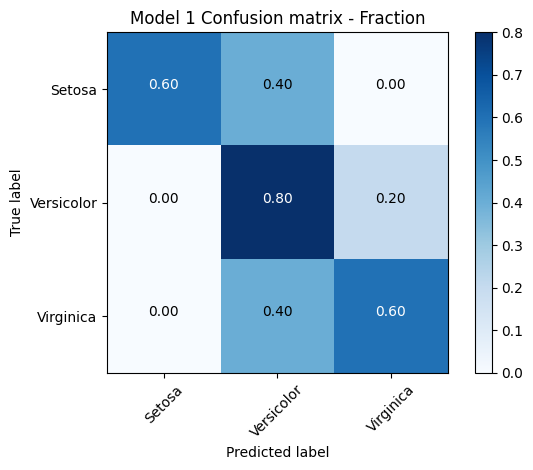

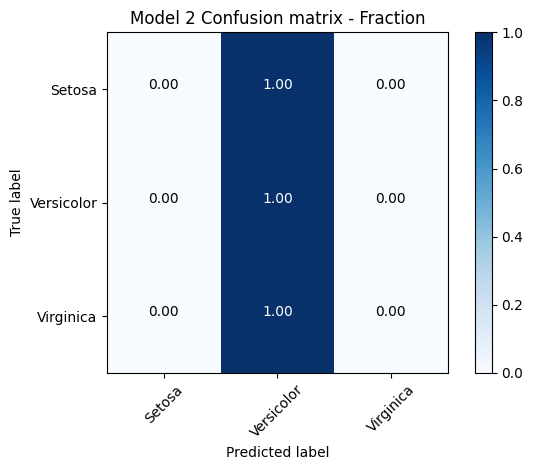

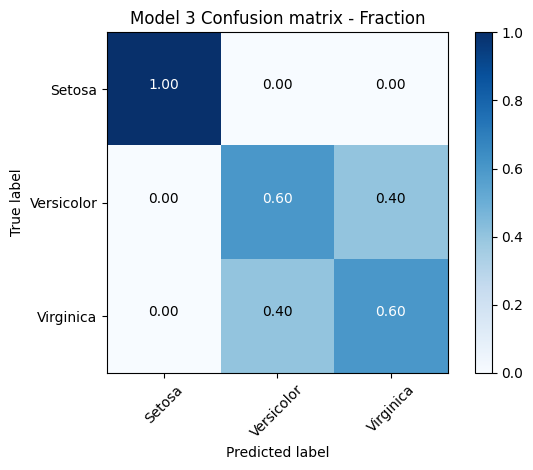

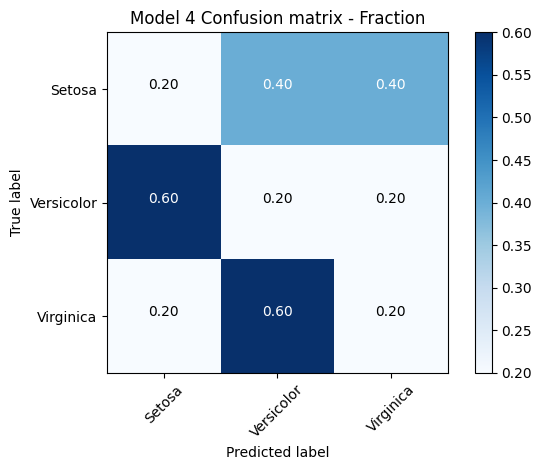

In [15]:
# Compute confusion matrix
# Show Ratio
for model in models:
    #print(model)
    cnf_matrix = confusion_matrix(df['NumericClass'],
                                  df[model.replace(' ','') + '_Prediction'],labels=labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title= model + ' Confusion matrix - Fraction', normalize=True)

In [16]:
# Using SKLearn classification report
# Micro vs Macro Average
# Reference:
#  https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
for model in models:
    print(model)
    print(classification_report(
    df['NumericClass'],
    df[model.replace(' ','') + '_Prediction'],
    labels=labels,
    target_names=classes))

Model 1
              precision    recall  f1-score   support

      Setosa       1.00      0.60      0.75         5
  Versicolor       0.50      0.80      0.62         5
   Virginica       0.75      0.60      0.67         5

    accuracy                           0.67        15
   macro avg       0.75      0.67      0.68        15
weighted avg       0.75      0.67      0.68        15

Model 2
              precision    recall  f1-score   support

      Setosa       0.00      0.00      0.00         5
  Versicolor       0.33      1.00      0.50         5
   Virginica       0.00      0.00      0.00         5

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15

Model 3
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         5
  Versicolor       0.60      0.60      0.60         5
   Virginica       0.60      0.60      0.60        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<h2>Summary</h2>

Macro average = Treat all classes equally.  Average of individual class scores

Weighted average = Take frequency of the classes into consideration.  

Weighted Average is recommended if there is uneven class distribution

In this example, Weighted Average of Model 1 and Model 3 are highest.

Reference:<br>
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

https://docs.aws.amazon.com/machine-learning/latest/dg/multiclass-classification.html